In [18]:
import math
from functools import partial
from collections import defaultdict
from typing import Any, Sequence
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state, common_utils
import optax
from typing import Callable, List, Optional

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tf.config.set_visible_devices([], 'GPU')

2024-10-20 18:54:00.690398: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
jax.local_devices()

[CudaDevice(id=0)]

In [4]:
rng = jax.random.PRNGKey(0)


2024-10-20 18:54:01.170947: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
def augment_image(img):
    img = tf.image.resize_with_crop_or_pad(img, 40, 40)
    img = tf.image.random_crop(img, [32, 32, 3])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img

def val_process_sample(x):
    image = tf.image.convert_image_dtype(x['image'], dtype=tf.float32)
    return {'image': image, 'label': x['label']}

def train_process_sample(x):
    image = augment_image(x['image'])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return {'image': image, 'label': x['label']}

def prepare_train_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='train')
    ds = ds.repeat()
    ds = ds.map(train_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    df = ds.shuffle(16 * batch_size, reshuffle_each_iteration=True, seed=0)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(10)
    return ds

def prepare_val_dataset(dataset_builder, batch_size):
    ds = dataset_builder.as_dataset(split='test')
    ds = ds.map(val_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(10)
    return ds

def tf_to_numpy(xs):
    return jax.tree_util.tree_map(lambda x: x._numpy(), xs)

def dataset_to_iterator(ds):
    it = map(tf_to_numpy, ds)
    return it

In [6]:
dataset_builder = tfds.builder('cifar10')
dataset_builder.download_and_prepare()

In [21]:
class ConvBlock(nn.Module):
    channels: int
    kernel_size: int
    norm: Any
    stride: int = 1
    act: bool = True
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.channels, (self.kernel_size, self.kernel_size), strides=self.stride,
                    padding='SAME', use_bias=False, kernel_init=nn.initializers.kaiming_normal())(x)
        x = self.norm()(x)
        if self.act:
            x = nn.swish(x)
        return x

class ResidualBlock(nn.Module):
    channels: int
    conv_block: Any
    
    @nn.compact
    def __call__(self, x):
        channels = self.channels
        conv_block = self.conv_block
        
        shortcut = x
        
        residual = conv_block(channels, 3)(x)
        residual = conv_block(channels, 3, act=False)(residual)
        
        if shortcut.shape != residual.shape:
            shortcut = conv_block(channels, 1, act=False)(shortcut)
        
        gamma = self.param('gamma', nn.initializers.zeros, 1, jnp.float32)
        out = shortcut + gamma * residual
        out = nn.swish(out)
        return out


class Stage(nn.Module):
    channels: int
    num_blocks: int
    stride: int
    block: Any
    
    @nn.compact
    def __call__(self, x):
        stride = self.stride
        if stride > 1:
            x = nn.max_pool(x, (stride, stride), strides=(stride, stride))
        for _ in range(self.num_blocks):
            x = self.block(self.channels)(x)
        return x

class Body(nn.Module):
    channel_list: Sequence[int]
    num_blocks_list: Sequence[int]
    strides: Sequence[int]
    stage: Any
    
    @nn.compact
    def __call__(self, x):
        for channels, num_blocks, stride in zip(self.channel_list, self.num_blocks_list, self.strides):
            x = self.stage(channels, num_blocks, stride)(x)
        return x

class Stem(nn.Module):
    channel_list: Sequence[int]
    stride: int
    conv_block: Any
    
    @nn.compact
    def __call__(self, x):
        stride = self.stride
        for channels in self.channel_list:
            x = self.conv_block(channels, 3, stride=stride)(x)
            stride = 1
        return x

class Head(nn.Module):
    classes: int

    @nn.compact
    def __call__(self, x):
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(self.classes)(x)
        return x

class ResNet(nn.Module):
    classes: int
    channel_list: Sequence[int]
    num_blocks_list: Sequence[int]
    strides: Sequence[int]
    head_p_drop: float = 0.
    
    @nn.compact
    def __call__(self, x):
        # norm = partial(nn.BatchNorm, use_running_average=not train)
        # dropout = partial(nn.Dropout, rate=self.head_p_drop, deterministic=not train)
        norm = nn.LayerNorm
        conv_block = partial(ConvBlock, norm=norm)
        residual_block = partial(ResidualBlock, conv_block=conv_block)
        stage = partial(Stage, block=residual_block)
        
        x = Stem([32, 32, 64], self.strides[0], conv_block)(x)
        x = Body(self.channel_list, self.num_blocks_list, self.strides[1:], stage)(x)
        x = Head(self.classes)(x)
        return x

In [22]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = common_utils.onehot(labels, num_classes=10)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels)
    loss = jnp.mean(loss)
    return loss

def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics

def metrics_summary(metrics):
    metrics = jax.device_get(metrics)
    metrics = jax.tree_multimap(lambda *args: np.stack(args), *metrics)
    summary = jax.tree_util.tree_map(lambda x: x.mean(), metrics)
    return summary

def log_metrics(history, summary, name):
    print(f"{name}: ", end='', flush=True)
    for key, val in summary.items():
        history[name + ' ' + key].append(val)
        print(f"{key} {val:.3f} ", end='')

In [65]:


model = ResNet(10,
               channel_list = [64, 128, 256, 512],
               num_blocks_list = [2, 2, 2, 2],
               strides = [1, 1, 2, 2, 2],
               head_p_drop = 0.3)

IMAGE_SIZE = 32

def initialize(model, params_rng):
    init_rngs = {'params': params_rng}
    input_shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3)
    variables = model.init(init_rngs, jnp.ones(input_shape, jnp.float32))
    return variables

params_rng, rng = jax.random.split(rng)
params_init = initialize(model, params_rng)


In [88]:
BATCH_SIZE = 64

train_steps_per_epoch = math.ceil(dataset_builder.info.splits['train'].num_examples / BATCH_SIZE)
val_steps_per_epoch = math.ceil(dataset_builder.info.splits['test'].num_examples / BATCH_SIZE)

train_ds = prepare_train_dataset(dataset_builder, BATCH_SIZE)
val_ds = prepare_val_dataset(dataset_builder, BATCH_SIZE)

train_iter = dataset_to_iterator(train_ds)
val_iter = dataset_to_iterator(val_ds)

2024-10-20 20:23:06.990526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [89]:
class ConvBlock(nn.Module):
    channels: int
    kernel_size: int
    norm: Any
    stride: int = 1
    act: bool = True
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(self.channels, (self.kernel_size, self.kernel_size), strides=self.stride,
                    padding='SAME', use_bias=False, kernel_init=nn.initializers.kaiming_normal())(x)
        x = self.norm()(x)
        if self.act:
            x = nn.swish(x)
        return x

In [90]:
class CNN(nn.Module):
    channels: int
    depth: int
    out_dim: int
    kernel_size: int

    @nn.compact
    def __call__(self, x):
        channels = self.channels

        if len(x.shape) < 2:
            x = x.reshape(-1,1)

        A = nn.swish
        for i, layer in enumerate(range(self.depth)):
            is_last = i == self.depth - 1
            if is_last:
                channels = self.out_dim
            L = nn.Conv(channels, (self.kernel_size, ), padding='SAME')
      
            x = L(x)
            
            if not is_last:
                x = A(x)

        x = jnp.squeeze(x)
        
        return x


In [91]:
from jax.flatten_util import ravel_pytree
from jax import jacfwd

params_flat, params_unravel = ravel_pytree(params_init)

channels = 16
mini_rngs, rng = jax.random.split(rng)
mini = CNN(channels=channels, depth=6, out_dim=1, kernel_size=4)
mini_params_init = mini.init(mini_rngs, jnp.ones( (*params_flat.shape,)))
mini_flat, _ = ravel_pytree(mini_params_init)

loss = mini.apply(mini_params_init, params_flat)
print(mini_flat.shape)

(4305,)


In [92]:
optimizer_mini = optax.adamw(learning_rate=2e-2)
state_opti_m = optimizer_mini.init(mini_params_init)

def mini_loss_fn(params, grad):
    mini_grad = mini.apply(params, grad)
    loss = jnp.linalg.norm(grad - mini_grad) / jnp.linalg.norm(grad)
    return loss


In [94]:
from tqdm.auto import tqdm
history = defaultdict(list)
epochs = 25
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

num_train_steps = train_steps_per_epoch * epochs

shedule_fn = optax.cosine_onecycle_schedule(transition_steps=num_train_steps, peak_value=LEARNING_RATE)
optimizer = optax.adamw(learning_rate=shedule_fn, weight_decay=WEIGHT_DECAY)
state_opti = optimizer.init(params_init)

mini_opt_iters = 8

def loss_fn(params, batch):
    logits = model.apply(params, batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    return loss, logits

@jax.jit
def train_step(params, batch, params_m, state_opti, state_opti_m):

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(params, batch)

    updates, state_opti = optimizer.update(grads, state_opti, params)
    params = optax.apply_updates(params, updates)  
    metrics = compute_metrics(logits, batch['label'])
    
    # update mini
    grads_flat, _ = ravel_pytree(grads)
    mini_grad_fn = jax.value_and_grad(mini_loss_fn)
    for _ in range(mini_opt_iters):
        m_loss, m_grads = mini_grad_fn(params_m, grads_flat)
        updates, state_opti_m = optimizer_mini.update(m_grads, state_opti_m, params_m)
        params_m = optax.apply_updates(params_m, updates)  

    metrics['m_loss'] = m_loss
    return params, params_m, state_opti, state_opti_m, metrics


@jax.jit
def eval_step(params, batch):
    logits = model.apply(params, batch['image'])
    metrics = compute_metrics(logits, batch['label'])
    return metrics

opt_params = params_init
opt_params_m = mini_params_init
for epoch in range(1, epochs + 1):
    
    train_metrics = []
    

    pbar = tqdm(range(train_steps_per_epoch), desc=f'epoch: {epoch}')

    for step in pbar:
        batch = next(train_iter)
        opt_params, opt_params_m, state_opti, state_opti_m, metrics = train_step(opt_params, batch, opt_params_m, state_opti, state_opti_m)
        pbar.set_postfix({'acc': f'{metrics["accuracy"]:.3f}', 'loss': f'{metrics["loss"]:.3E}', 'm_loss': f'{metrics["m_loss"]:.3E}'})

    train_metrics.append(metrics)

    # summary = metrics_summary(train_metrics)
    # log_metrics(history, summary, 'train')

    val_metrics = []
    for step in range(val_steps_per_epoch):
        batch = next(val_iter)
        metrics = eval_step(opt_params, batch)
        val_metrics.append(metrics)
    
    print(metrics)
    # print()



epoch: 1:   0%|          | 0/782 [00:00<?, ?it/s]

{'accuracy': Array(0.375, dtype=float32), 'loss': Array(1.5003564, dtype=float32)}


epoch: 2:   0%|          | 0/782 [00:00<?, ?it/s]

{'accuracy': Array(0.5, dtype=float32), 'loss': Array(1.2846218, dtype=float32)}


epoch: 3:   0%|          | 0/782 [00:00<?, ?it/s]

{'accuracy': Array(0.625, dtype=float32), 'loss': Array(0.9605688, dtype=float32)}


epoch: 4:   0%|          | 0/782 [00:00<?, ?it/s]

{'accuracy': Array(0.75, dtype=float32), 'loss': Array(1.0181952, dtype=float32)}


epoch: 5:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
val_metrics

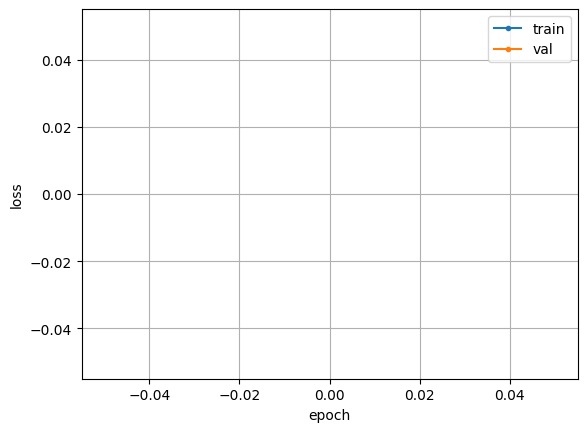

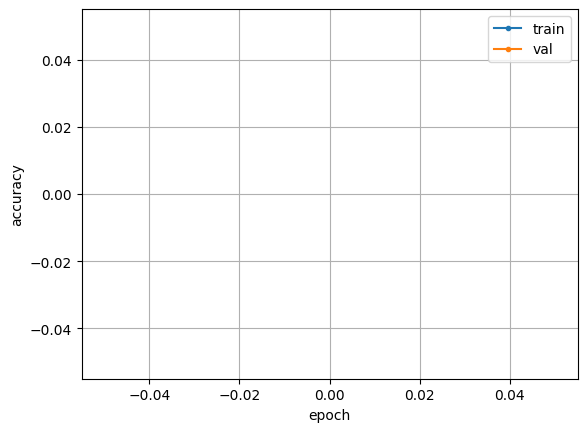

In [16]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

plot_history_train_val(history, 'loss')
plot_history_train_val(history, 'accuracy')
